# Movies recommendation engine
Pierre-Yves BOISBUNON - October 2017


----------

The target is to elaborate a movie recommendation engine based on the dataset **movie_metadata.csv** IMDB database.

Tags:
- Clustering (PCA, KMeans)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# 1. Exploration and Cleaning

Let's open the dataset:

In [7]:
!apt-get install wget

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  wget
0 upgraded, 1 newly installed, 0 to remove and 2 not upgraded.
Need to get 299 kB of archives.
After this operation, 905 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu xenial-updates/main amd64 wget amd64 1.17.1-1ubuntu1.4 [299 kB]
Fetched 299 kB in 0s (327 kB/s)
debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package wget.
(Reading database ... 14043 files and directories currently installed.)
Preparing to unpack .../wget_1.17.1-1ubuntu1.4_amd64.deb ...
Unpacking wget (1.17.1-1ubuntu1.4) ...
Setting up wget (1.17.1-1ubuntu1.4) ...


In [8]:
!wget https://raw.githubusercontent.com/sundeepblue/movie_rating_prediction/master/movie_metadata.csv

--2018-10-16 10:34:13--  https://raw.githubusercontent.com/sundeepblue/movie_rating_prediction/master/movie_metadata.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.120.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.120.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1494688 (1.4M) [text/plain]
Saving to: 'movie_metadata.csv'

movie_metadata.csv  100%[===================>]   1.42M  1.22MB/s    in 1.2s    

2018-10-16 10:34:16 (1.22 MB/s) - 'movie_metadata.csv' saved [1494688/1494688]



In [93]:
df_train = pd.read_csv('movie_metadata.csv', sep=',')

In [94]:
df_train.shape

(5043, 28)

In [95]:
df_train.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


## 1.1. Analyse missing data

Let's analyse missing data contained in dataset

Text(0, 0.5, '')

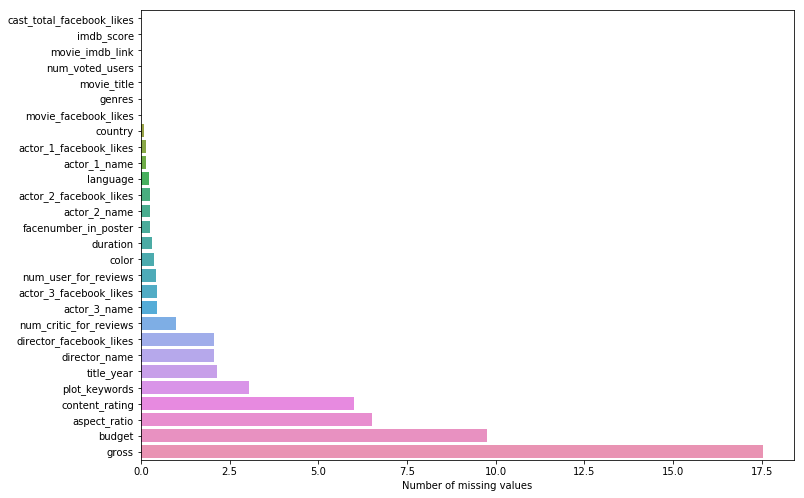

In [96]:
col = df_train.columns.get_values()
y = []
for var in col:
    missing = float(df_train[var].isnull().sum())
    count = float(df_train[var].count() + 1)
    y.append(float(missing/(missing+count)) * 100)
    
my_df = pd.DataFrame({'index': col, 'missing_values': y})
my_df = my_df.sort_values('missing_values')

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

sns.barplot(x='missing_values', y="index", data=my_df, ax=ax)
ax.set_xlabel('Number of missing values')
ax.set_ylabel('')

Let's fill dataset missing column with mean value for numeric values.

In [97]:
df_train.fillna(df_train.mean(), inplace=True)

Let's drop now all non defined values

In [98]:
cols = df_train.columns.values
for var in cols:
    df_train = df_train.dropna(subset=[var], how='all')
df_train.shape

(4581, 28)

## 1.2 Analyse categoric variable

Let's observe the amount of unique value per categoric variable

Text(0, 0.5, '')

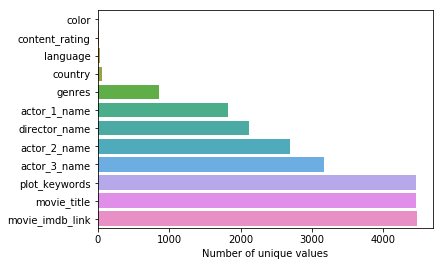

In [99]:
df_train_cat = df_train.select_dtypes(include=['object'])
y = []
x = df_train_cat.columns.get_values()
for var in x:
    y.append(len(df_train_cat[var].unique()))

my_df = pd.DataFrame({'index': x, 'unique_values': y})
my_df = my_df.sort_values('unique_values')
ax = sns.barplot(x='unique_values', y="index", data=my_df)

ax.set_xlabel('Number of unique values')
ax.set_ylabel('')

**plot_keywords** and **movie_imdb_link** show a lot of unique values (equal to the amount of movie_title)

### 1.2.1 Utils API

Let's define some generic functions that we could use later

** Function encoding var **: the row **var** value is compared to the expected **value** if equal return **positive_value** else **negative_value**

In [100]:
def encode_var(row, var, value, positive_value, negative_value):
    if row[var].find(value)> -1:
        return positive_value
    else:
        return negative_value

** Function encoding var in binary**: the row **var** value is compared to the expected **value** if equal return 1 else 0

In [101]:
def binary_encode_var(row, var, value):
    return encode_var(row, var, value, 1, 0)

** Function encoding var in binary (exclusion)**: the row **var** value is compared to the expected **values** list separated by a **separator**. 
If the **var** is not in the list, it returns 0 else 1

In [102]:
def binary_encode_var_exclude(row, var, values, separator):
    for value in values.split(separator):
        if (encode_var(row, var, value, 1, 0) == 1):
            return 0
    return 1

### 1.2.2 color

Let's analyse **color** variable

In [103]:
df_train['color'].unique()

array(['Color', ' Black and White'], dtype=object)

In [104]:
df_train['color'].describe()

count      4581
unique        2
top       Color
freq       4392
Name: color, dtype: object

As there is only two different values, We will use label encoder to encode both of them (it will then be a binary encoding).

### 1.2.3 content_rating

Let's analyse **content_rating**

In [105]:
df_train['content_rating'].unique()

array(['PG-13', 'PG', 'G', 'R', 'TV-14', 'Not Rated', 'Unrated',
       'Approved', 'NC-17', 'X', 'GP', 'Passed', 'M', 'TV-G', 'TV-PG'],
      dtype=object)

### 1.2.4 language

Let's analyse **language**

In [106]:
languages = df_train['language'].unique()

Let's observe the number of occurence of each languages

Text(0, 0.5, '')

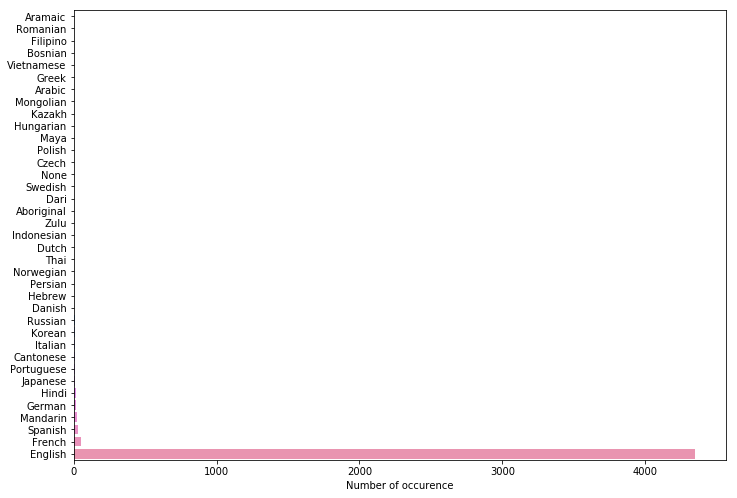

In [107]:
my_df = pd.DataFrame({'index': df_train['language'].value_counts().index, 'nb_occurence': df_train['language'].value_counts()})
my_df = my_df.sort_values('nb_occurence')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.barplot(x='nb_occurence', y="index", data=my_df, ax=ax)

ax.set_xlabel('Number of occurence')
ax.set_ylabel('')

Most of languages are 'english','french' and 'spanish'. I propose to create 3 features based on them and create an 'other_language' categorie for the rest.

In [108]:
df_train['english_lang'] = df_train['language'].apply(lambda x: int('English' in str(x)))
df_train['french_lang'] = df_train['language'].apply(lambda x: int('French' in str(x)))
df_train['spanish_lang'] = df_train['language'].apply(lambda x: int('Spanish' in str(x)))
df_train['other_lang'] = df_train['language'].apply(lambda x: int((not 'English' in x) and (not 'French' in x) and (not 'Spanish' in x)))

In [109]:
df_train.drop('language', inplace=True, axis=1)

### 1.2.5 plot_keywords

Let's analyse **plot_keywords**

In [110]:
len(df_train['plot_keywords'].unique())

4458

In [111]:
# Create 'keywords' list
keywords = []
for elem in df_train['plot_keywords'].str.split('|').values:
    for val in [val for val in elem if val not in keywords]:
        keywords.append(val)
print(len(keywords))

7746


**plot_keywords** seems to be a specific field filled with commented values. It contains almost the same amount of different combinaison than the number of entry in the dataset. Let's remove it

In [112]:
df_train.drop('plot_keywords', inplace=True, axis=1)

### 1.2.5 movie_imdb_link

Let's analyse **movie_imbd_link**

In [113]:
df_train['movie_imdb_link'].unique()

array(['http://www.imdb.com/title/tt0499549/?ref_=fn_tt_tt_1',
       'http://www.imdb.com/title/tt0449088/?ref_=fn_tt_tt_1',
       'http://www.imdb.com/title/tt2379713/?ref_=fn_tt_tt_1', ...,
       'http://www.imdb.com/title/tt0430371/?ref_=fn_tt_tt_1',
       'http://www.imdb.com/title/tt1880418/?ref_=fn_tt_tt_1',
       'http://www.imdb.com/title/tt0378407/?ref_=fn_tt_tt_1'],
      dtype=object)

Filled of url link, no need to keep it

In [114]:
df_train.drop('movie_imdb_link', inplace=True, axis=1)

### 1.2.6 genres

Let's analyse **genres**

In [115]:
df_train['genres'].unique()

array(['Action|Adventure|Fantasy|Sci-Fi', 'Action|Adventure|Fantasy',
       'Action|Adventure|Thriller', 'Action|Thriller',
       'Action|Adventure|Sci-Fi', 'Action|Adventure|Romance',
       'Adventure|Animation|Comedy|Family|Fantasy|Musical|Romance',
       'Adventure|Family|Fantasy|Mystery', 'Action|Adventure',
       'Action|Adventure|Western', 'Action|Adventure|Family|Fantasy',
       'Action|Adventure|Comedy|Family|Fantasy|Sci-Fi',
       'Adventure|Fantasy', 'Action|Adventure|Drama|History',
       'Adventure|Family|Fantasy', 'Action|Adventure|Drama|Romance',
       'Drama|Romance', 'Action|Adventure|Sci-Fi|Thriller',
       'Action|Adventure|Fantasy|Romance',
       'Action|Adventure|Fantasy|Sci-Fi|Thriller',
       'Adventure|Animation|Comedy|Family|Fantasy',
       'Adventure|Animation|Comedy|Family|Sport', 'Action|Crime|Thriller',
       'Action|Adventure|Horror|Sci-Fi|Thriller',
       'Adventure|Animation|Family|Sci-Fi',
       'Action|Comedy|Crime|Thriller', 'Animation|

The different genres are separated with a '|', let's create a unique list of genres

In [116]:
import operator
# Create 'genres' list
genres = []
for elem in df_train['genres'].str.split('|').values:
    for val in [val for val in elem if val not in genres]:
        genres.append(val)

Let's analyse the number of each occurences of genres

In [117]:
genres_occurences = dict.fromkeys(genres, 0)
for elem in df_train['genres'].str.split('|'):
    for val in [val for val in elem if val in genres]:
            genres_occurences[val] += 1
# Sort descending order
genres_occurences = sorted(genres_occurences.items(), key=operator.itemgetter(1), reverse=True)
print(genres_occurences)

[('Drama', 2338), ('Comedy', 1737), ('Thriller', 1310), ('Action', 1085), ('Romance', 1033), ('Adventure', 880), ('Crime', 822), ('Sci-Fi', 578), ('Fantasy', 573), ('Horror', 515), ('Family', 508), ('Mystery', 454), ('Biography', 278), ('Animation', 226), ('Music', 199), ('War', 192), ('History', 188), ('Sport', 179), ('Musical', 122), ('Western', 86), ('Documentary', 75), ('Film-Noir', 5), ('News', 1)]


Text(0, 0.5, '')

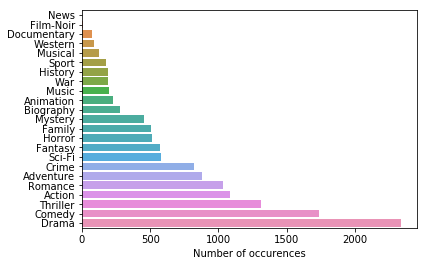

In [118]:
y = []
x = []
for var in genres_occurences:
    y.append(var[0])
    x.append(var[1])

my_df = pd.DataFrame({'occurences': x, 'index': y})
my_df = my_df.sort_values('occurences')
ax = sns.barplot(x='occurences', y="index", data=my_df)

ax.set_xlabel('Number of occurences')
ax.set_ylabel('')

Most of movies are with the genre 'Drama', 'Comedy'.
'News' and 'Film-Noir' are with the lowest quantity
Let's create new features based on each genre labels.

In [119]:
for genre in genres:
    df_train[genre] = df_train.apply(lambda row: binary_encode_var(row, 'genres', genre), axis=1)

In [120]:
df_train.drop('genres', inplace=True, axis=1)

### 1.2.7 encoding remaining categorical variables (except movie_title)

In order to facilitate elaboration of movie engine, I propose to encode categorical variables in order to get a full dataset with numeric values except movie_title.

In [121]:
categorical_variables = df_train.select_dtypes(include=['object']).columns
categorical_variables

Index(['color', 'director_name', 'actor_2_name', 'actor_1_name', 'movie_title',
       'actor_3_name', 'country', 'content_rating'],
      dtype='object')

In [122]:
from sklearn import preprocessing

for var in categorical_variables:
    if (var != 'movie_title'):
        le = preprocessing.LabelEncoder()
        le.fit(df_train[var].unique())
        df_train[var] = le.transform(df_train[var])

### 1.2.8 Movie title

Let's analyse 'movie_title' variable

In [123]:
df_train['movie_title'].unique()

array(['Avatar\xa0', "Pirates of the Caribbean: At World's End\xa0",
       'Spectre\xa0', ..., 'The Mongol King\xa0', 'Newlyweds\xa0',
       'My Date with Drew\xa0'], dtype=object)

Let's remove the trailing caracters

In [124]:
df_train['movie_title'].replace(regex=True,inplace=True,to_replace=r'\xc2\xa0',value=r'')

In [125]:
df_train['movie_title'].describe()

count     4581
unique    4462
top       Pan 
freq         3
Name: movie_title, dtype: object

We can see there are duplicated variables, let's remove them

In [126]:
df_train.drop_duplicates('movie_title', inplace=True)

### 1.2.9 Reset index

In [127]:
df_train = df_train.reset_index(drop=True)

## 1.3 Correlation view

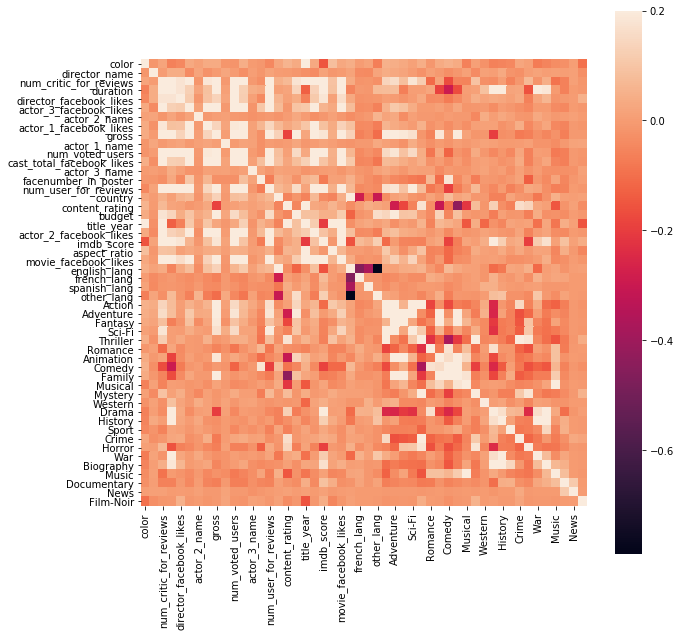

In [128]:
#correlation matrix removing id/title
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corrmat, vmax=0.2, square=True);

# 1.4 Modelizations

Let's start by standardize all variables (except ** movie_title ** that stays a categorize variable)

In [129]:
# Normalize only numeric column
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_selection = df_train.select_dtypes(include=numerics).columns

In [135]:
X_norm=preprocessing.scale(df_train[num_selection])

In [140]:
scaler = preprocessing.StandardScaler().fit(df_train[num_selection])
X_scaled = scaler.transform(df_train[num_selection])

### 1.4.1 Clustering

Let's try to separate datasets into several clusters observing silouhette score.

#### 1.4.1 Principal Component Analysis

Let's analyse the 4 clusters using PCA.

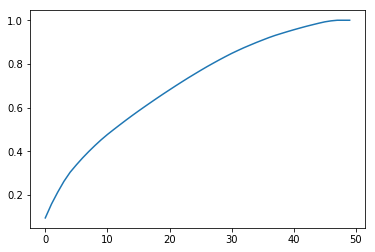

In [141]:
from sklearn import decomposition
pca = decomposition.PCA().fit(X_scaled) 
plt.plot(np.cumsum(pca.explained_variance_ratio_)) 
plt.show()
X_trans = pca.transform(X_scaled)

In [142]:
variance_sum = 0
for i in range(30):
    variance_sum += pca.explained_variance_ratio_[i]
print(variance_sum)

0.8335417395586956


The **30** first component explains more than 84% of the variance
Let's visualize the data projected on the two first dimension dimension of PCA.

In [146]:
pca = decomposition.PCA(n_components=30).fit(X_scaled) 
X_trans = pca.transform(X_scaled)

#### 1.4.2 Kmeans

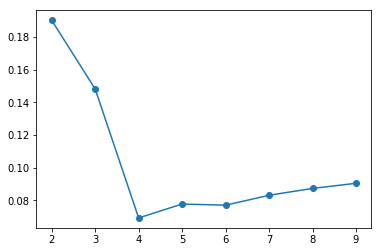

In [160]:
from sklearn import cluster, metrics
from sklearn import preprocessing
silhouettes = []
for num_clusters in range(2, 10):
    cls = cluster.KMeans(n_clusters=num_clusters, n_init=1, init='random', random_state=10)
    labels = cls.fit_predict(X_trans)
    silh = metrics.silhouette_score(X_trans, labels)
    silhouettes.append(silh)
plt.plot(range(2,10), silhouettes, marker='o')

We can select 3 clusters, silhouette is maximum in that case. We also observe that the silhouette score is really small indicating risk of overlapping in the clusters.

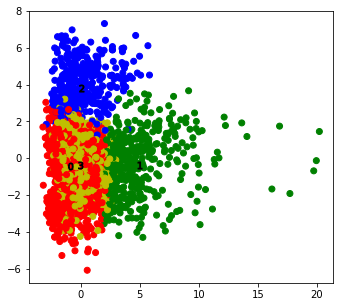

In [182]:
from sklearn.pipeline import Pipeline
scaler = preprocessing.StandardScaler()
pca = decomposition.PCA(n_components=30)
kmeans = cluster.KMeans(n_clusters=4, n_init=1, init='random', random_state=10)

X = df_train[num_selection]
pipe = [
        ('scaler', scaler),
        ('pca', pca),
        ('kmeans', kmeans)
]

pipe = Pipeline(pipe)
pipe.fit(X)

X_scaled = pipe.named_steps['scaler'].transform(X)
X_trans = pipe.named_steps['pca'].transform(X_scaled)
labels = pipe.fit_predict(X)
centers = pipe.named_steps['kmeans'].cluster_centers_

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
# Force cluster color
LABEL_COLOR_MAP = {0 : 'r',1 : 'g',2 : 'b', 3: 'y'}
label_color = [LABEL_COLOR_MAP[l] for l in labels]
ax.scatter(X_trans[:,0], X_trans[:,1], c=label_color)
# Plot cluster center
for i, center in enumerate(centers):
    plt.scatter(center[0], center[1], marker='${}$'.format(i), alpha=1, s=50, edgecolor='k')

The 4 clusters are not clearly separated.

Let's quantify the correspondance between each column of the dataset and the labels of the cluster using the adjusted rand score.

Text(0, 0.5, '')

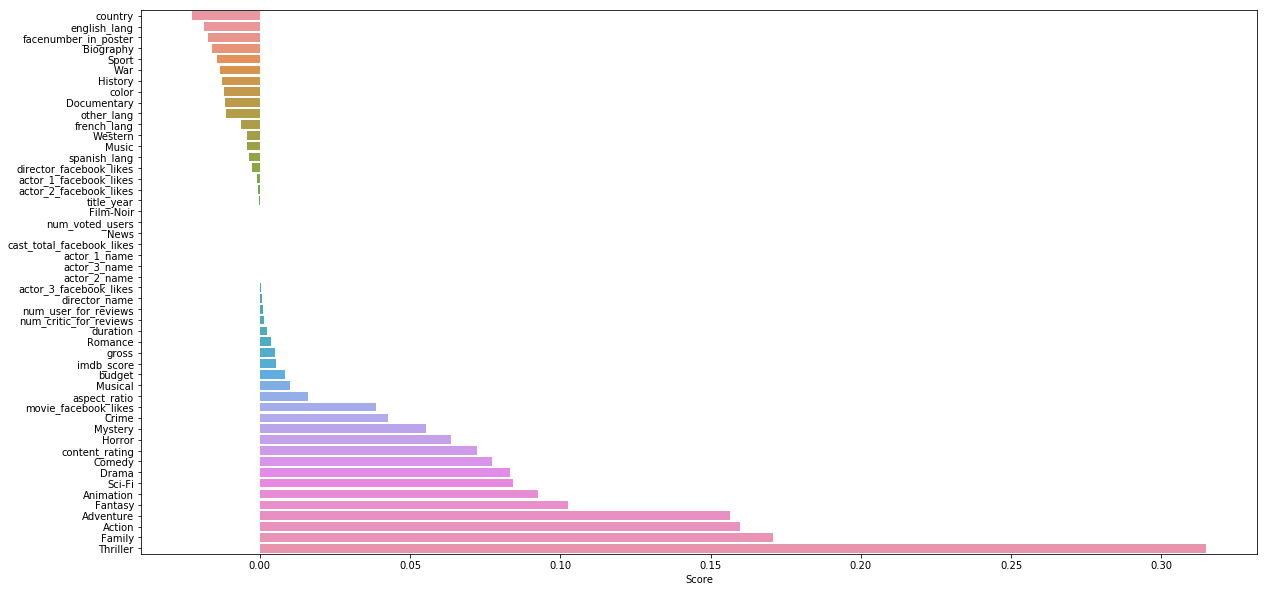

In [183]:
x = num_selection
y = [metrics.adjusted_rand_score(df_train[sel], labels) for sel in x]


fig = plt.figure(figsize=(20,10)) 
my_df = pd.DataFrame({'score': y, 'index': x})
my_df = my_df.sort_values('score')
ax = sns.barplot(x='score', y="index", data=my_df)

ax.set_xlabel('Score')
ax.set_ylabel('')

The 'Thriller' has the biggest adjusted rand score, but the score is not really high. We don't have really distinguable cluster. Let's work on movie engine.

# 2. Movie Engine

The principe that I choose for the movie engine is the **content-based filtering**.
I will use:
- Notes: num_voted_users, num_user_for_reviews et imdb_score.
- Characters selection: actors and director names
- Genre selection
- Other selection as color and language
I declare the variable **criteria_selection**

In [221]:
criteria_selection = ['color', 'director_name','actor_2_name', 'actor_1_name', 'actor_3_name',
                      'content_rating', 'budget', 'title_year', 'imdb_score', 'english_lang', 'french_lang', 'spanish_lang',
                      'other_lang', 'Action', 'Adventure', 'Fantasy', 'Sci-Fi', 'Thriller', 'Romance', 'Animation', 'Comedy', 
                      'Family', 'Musical', 'Mystery', 'Western', 'Drama', 'History', 'Sport', 'Crime', 'Horror', 'War', 'Biography', 
                      'Music', 'Documentary', 'Film-Noir']
df = df_train[criteria_selection].copy(deep=True)

In [222]:
df['movie_title'] = df_train['movie_title']

## 2.2 Different ponderations

** Function returning default ponderation**: all the variables have the same priority

In [185]:
def get_default_weights():
    #        ['color','director_name', 'duration', 'actor_2_name', 'actor_1_name', 'actor_3_name', 'country', 
    return   [ 1, 1, 1, 1, 1, 1, 1,
    #        'content_rating', 'budget', 'title_year', 'imdb_score', 'english_lang', 'french_lang', 'spanish_lang',
              1, 1, 1, 1, 1, 1, 1,
    #        'other_lang', 'Action', 'Adventure', 'Fantasy', 'Sci-Fi', 'Thriller', 'Romance', 'Animation', 'Comedy', 
              1, 1, 1, 1, 1, 1, 1, 1, 1,
    #        'Family', 'Musical', 'Mystery', 'Western', 'Drama', 'History', 'Sport', 'Crime', 'Horror', 'War', 'Biography', 
              1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    #        'Music', 'Documentary', 'Film-Noir']
              1, 1, 1]

** Function returning ponderation selection 1**: highest ponderation for genres and consider only color, actor_1_name, country and languages as key features.

In [186]:
def get_pond1_weights():
    #        ['color','director_name', 'duration', 'actor_2_name', 'actor_1_name', 'actor_3_name', 'country', 
    return   [ 1, 0, 0, 0, 1, 0, 1,
    #        'content_rating', 'budget', 'title_year', 'imdb_score', 'english_lang', 'french_lang', 'spanish_lang',
              0, 0, 0, 0, 1, 1, 1,
    #        'other_lang', 'Action', 'Adventure', 'Fantasy', 'Sci-Fi', 'Thriller', 'Romance', 'Animation', 'Comedy', 
              1, 1, 1, 1, 1, 1, 1, 1, 1,
    #        'Family', 'Musical', 'Mystery', 'Western', 'Drama', 'History', 'Sport', 'Crime', 'Horror', 'War', 'Biography', 
              1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    #        'Music', 'Documentary', 'Film-Noir']
              1, 1, 1]

## 2.3 Movie engine core

** Function of ponderation**: input **x** is ponderated by **matrix** through **array_selection**.

In [187]:
def ponderate(x, matrix, array_selection):
    z = np.copy(x)
    for i in range(len(array_selection)):
        z[:,i] *= matrix[i]
    return z

**Function of similarity**: two titles are compared, it returns true if both are closed

In [188]:
from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

def sequel(movie_title_1, movie_title_2):
    if (similar(movie_title_1, movie_title_2) > 0.6):
        return True
    else:
        return False

**Function of index**: return index of movie title in the dataframe **df**

In [215]:
def find_entry(df, title):
    index =  df[df.movie_title == title].index
    if (len(index) == 0):
        return -1
    else:
        return index[0]

**Function of recommendation**: return first twentiest movie title closer to the **id_entry** movie

In [190]:
from sklearn.neighbors import NearestNeighbors
def recommend(x, df, id_entry):
    nbrs = NearestNeighbors(n_neighbors=20, algorithm='auto', metric='euclidean').fit(x)
    X_test = x[id_entry,:]
    X_test = X_test.reshape(1, -1)
    distances, indices = nbrs.kneighbors(X_test)
    list_films = []
    # Remove first element as it's the title...
    for i in range(1, 20):
        list_films.append(df.get_value(indices[0][i], 'movie_title'))
    return list_films

**Function of sequel deletion**: remove all film that are too closed

In [191]:
def del_sequels(film_list):  
    # First element is considered with highest priority
    keeped = []
    removed = []
    for film_1 in enumerate(film_list):
        keeped.append(film_1[1])
        for film_2 in enumerate(film_list):
            if (film_1[1] != film_2[1]):
                if sequel(film_1[1], film_2[1]) and (not film_2[1] in keeped): 
                    last_film = film_2[1]
                    removed.append(last_film)

    film_list = [film for film in film_list if film not in removed]

    return film_list 

**Function of movie engine**: entry point for the movie engine

In [192]:
def movie_engine(df, title, x, weights, remove_sequel):
    index = find_entry(df, title)
    X_norm_ponderate = ponderate(x, weights, criteria_selection)
    film_selection = recommend(X_norm_ponderate, df, index)
    if remove_sequel:
        film_selection = remove_sequels(film_selection)
    return [dict(id=find_entry(df, film), name=film) for film in film_selection[:5]]

Let's start by normalize input dataframe.

In [231]:
col = list(df.columns)
col.pop()
X_norm = preprocessing.scale(df[col])

### Test on 'Star Wars: Episode III - Revenge of the Sith'

Fantasy movie with sequel from 2005

In [232]:
ret = movie_engine(df, 'Star Wars: Episode III - Revenge of the Sith', X_norm, get_default_weights(), False)
default_result = [res['name'] for res in ret]
ret = movie_engine(df, 'Star Wars: Episode III - Revenge of the Sith', X_norm, get_pond1_weights(), False)
pond1_result = [res['name'] for res in ret]
##_________________________________________________________________________________________________________________##
my_df = pd.DataFrame({'Default': default_result, 'Ponderation1': pond1_result})
my_df

,Default,Ponderation1
0,Star Wars: Episode II - Attack of the Clones,Star Wars: Episode II - Attack of the Clones
1,Star Wars: Episode I - The Phantom Menace,Star Wars: Episode I - The Phantom Menace
2,The Amazing Spider-Man 2,Star Wars: Episode VI - Return of the Jedi
3,X-Men 2,Man of Steel
4,Man of Steel,Star Wars: Episode IV - A New Hope


The ponderation 'pond1' looks better (we have 4 episodes of Star Wars).
We can see that not all the films from Star Wars does not appears, as Natalie Portman appears only in episode I, II and III.

### Test on 'Closer'

Dramatic movie from 2004

In [233]:
ret = movie_engine(df, 'Closer', X_norm, get_default_weights(), False)
default_result = [res['name'] for res in ret]
ret = movie_engine(df, 'Closer', X_norm, get_pond1_weights(), False)
pond1_result = [res['name'] for res in ret]
##_________________________________________________________________________________________________________________##
my_df = pd.DataFrame({'Default': default_result, 'Ponderation1': pond1_result})
my_df

,Default,Ponderation1
0,Mother and Child,The Best of Me
1,My Summer of Love,Up in the Air
2,The Heart of Me,Oscar and Lucinda
3,The End of the Affair,Vicky Cristina Barcelona
4,Revolutionary Road,Shopgirl


The ponderation 'default' seems to look better than 'ponderation1' as 'Shopgirl' is not a dramatic movie.

### Test on 'The Artist'

Dramatic movie from 2011 in black and white color.

In [234]:
ret = movie_engine(df, 'The Artist', X_norm, get_default_weights(), False)
default_result = [res['name'] for res in ret]
ret = movie_engine(df, 'The Artist', X_norm, get_pond1_weights(), False)
pond1_result = [res['name'] for res in ret]
##_________________________________________________________________________________________________________________##
my_df = pd.DataFrame({'Default': default_result, 'Ponderation1': pond1_result})
my_df

,Default,Ponderation1
0,Frances Ha,The Apartment
1,Clerks II,You Can't Take It with You
2,Clerks,Nothing But a Man
3,Celebrity,Amélie
4,Barbershop 2: Back in Business,Gentleman's Agreement


The ponderation 'pond1' looks better: all the movies are in black and white except 'Amélie'

## 2.4 Error cases

### Test on 'Psycho'

Horror movie from 1960

In [235]:
ret = movie_engine(df, 'Psycho', X_norm, get_pond1_weights(), False)
pond1_result = [res['name'] for res in ret]
##_________________________________________________________________________________________________________________##
my_df = pd.DataFrame({'Ponderation1': pond1_result})
my_df

,Ponderation1
0,The Skeleton Key
1,Memento
2,Night of the Living Dead
3,The Good German
4,Pi


The ponderation 'pond1' looks failing:
- 'Memento' is not horror movies. 'Night of the Living Dead' should be presented first.

### Test on 'Das Boot'

German war movie from 1981

In [236]:
ret = movie_engine(df, 'Das Boot', X_norm, get_default_weights(), False)
pond1_result = [res['name'] for res in ret]
##_________________________________________________________________________________________________________________##
my_df = pd.DataFrame({'Ponderation1': pond1_result})
my_df

,Ponderation1
0,Black Book
1,Tae Guk Gi: The Brotherhood of War
2,Earth
3,I Served the King of England
4,My Name Is Khan


The 'genre' is respected but not the language. The movie 'Tae Guk Gi...' is in Korean.

In [238]:
df.to_csv('./api/movieengineapp/static/movies.csv', index=False)

# 3 Conclusion

The movie engine behaves not so bad but the error cases raises some point to adress:
- the creation of a specific feature for sequel could be interesting
- the management of 'plot_keywords' should also help in case of finding movie with genre sparsely represented